<a href="https://colab.research.google.com/github/LennyRBriones/neural-networks-practices/blob/main/Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import os
import zipfile

local_zip ="/content/drive/MyDrive/brain_class.zip"
zip_ref = zipfile.ZipFile(local_zip,"r")
zip_ref.extractall("content/drive/MyDrive/brain_class")
zip_ref.close()

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_dir = "content/drive/MyDrive/brain_class/Training"
test_dir = "content/drive/MyDrive/brain_class/Testing"

## Data Generators

In [4]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2) # splitting in 20% to validate performance

In [5]:
from tensorflow.python import test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset ="training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
)

Found 5712 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [6]:
classes = ["glioma", "meningioma", "notumor", "pituitary"]

In [7]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [8]:
def plotimages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (15,15))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

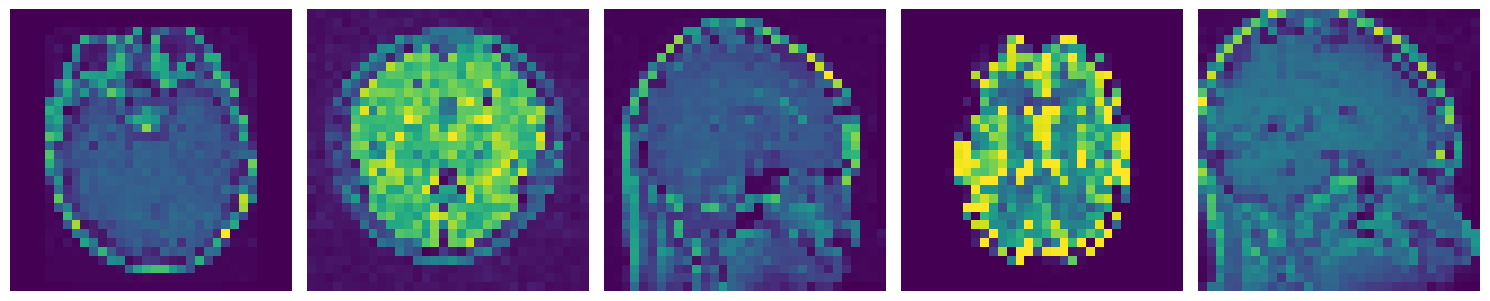

In [9]:
sample_training_images, _ = next(train_generator)
plotimages(sample_training_images[5:10])

## Keras Tuner

In [10]:
from tensorflow.keras import regularizers

In [11]:
! pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.0 MB/s eta 0:00:00


In [12]:
def model_constructor(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(20, (3,3), activation ="relu", input_shape = (32,32, 1)))
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())

  #Dynamic generator of neurons
  hp_units = hp.Int("units", min_value = 10, max_value = 80, step = 10)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(classes), activation = "softmax" ))

  hp_learning_rate = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate= hp_learning_rate), loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

In [13]:
tuner = kt.Hyperband(
    model_constructor,
    objective = "val_accuracy", #to see generalization in new data
    max_epochs=12,
    factor = 3,
    directory = "models/",
    project_name = "brain-lenn-tunner"
)

In [14]:
tuner.search(train_generator, epochs = 12, validation_data = validation_generator)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
                                          #trials help us to re-test the result

Trial 30 Complete [00h 03m 52s]
val_accuracy: 0.7290076613426208

Best val_accuracy So Far: 0.919847309589386
Total elapsed time: 00h 44m 15s


In [15]:
print(best_hps.get("units")) #to get the best configuration of neurons

70


In [16]:
print(best_hps.get("learning_rate")) #to get the best configuration of learning rate

0.001


In [17]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "auto") #it could be min or max depends of the metric

In [18]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hypermodel = hypermodel.fit(
    train_generator,
    epochs = 12,
    callbacks = [callback_early],
    validation_data = validation_generator
)

Epoch 1/12
476/476 [==============================] - 19s 36ms/step - loss: 0.8998 - accuracy: 0.6131 - val_loss: 0.8801 - val_accuracy: 0.6679
Epoch 2/12
476/476 [==============================] - 19s 39ms/step - loss: 0.5691 - accuracy: 0.7798 - val_loss: 0.6755 - val_accuracy: 0.6794
Epoch 3/12
476/476 [==============================] - 18s 37ms/step - loss: 0.4587 - accuracy: 0.8300 - val_loss: 0.6305 - val_accuracy: 0.6947
Epoch 4/12
476/476 [==============================] - 17s 37ms/step - loss: 0.3888 - accuracy: 0.8517 - val_loss: 0.5082 - val_accuracy: 0.7786
Epoch 5/12
476/476 [==============================] - 18s 38ms/step - loss: 0.3475 - accuracy: 0.8683 - val_loss: 0.4343 - val_accuracy: 0.8244
Epoch 6/12
476/476 [==============================] - 17s 36ms/step - loss: 0.3081 - accuracy: 0.8836 - val_loss: 0.5035 - val_accuracy: 0.8053
Epoch 7/12
476/476 [==============================] - 18s 38ms/step - loss: 0.2741 - accuracy: 0.9025 - val_loss: 0.4004 - val_accuracy:

In [19]:
# to save the config of the model
config_dict = hypermodel.get_config()

In [20]:
print(config_dict)

{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_1_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 32, 32, 1), 'filters': 20, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}}, 

In [21]:
model_same_config = tf.keras.Sequential.from_config(config_dict)

In [22]:
model_same_config.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 20)        200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4500)              0         
                                                                 
 dense_3 (Dense)             (None, 70)                315070    
                                                                 
 dropout_2 (Dropout)         (None, 70)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                710       
                                                      

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
def get_model():
   model = tf.keras.models.Sequential([
             tf.keras.layers.Conv2D(20, (3,3), activation = "relu", input_shape = (32, 32,1)),
             tf.keras.layers.MaxPool2D((2,2)),
             tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(40, kernel_regularizer= regularizers.l2(0.001), activation = "relu"),
             tf.keras.layers.Dropout(0.2),
             tf.keras.layers.Dense(10, kernel_regularizer= regularizers.l2(0.001), activation = "relu"),
             tf.keras.layers.Dropout(0.2),
             tf.keras.layers.Dense(len(classes), activation ="softmax")
   ])
   return model

model_early =  get_model()
model_early.summary()

model_early.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 20)        200       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4500)              0         
                                                                 
 dense_6 (Dense)             (None, 40)                180040    
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                410       
                                                      

In [25]:
model_weight = get_model()
model_weight.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 20)        200       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 20)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4500)              0         
                                                                 
 dense_9 (Dense)             (None, 40)                180040    
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                410       
                                                      

In [26]:
model_weight.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [27]:
checkpoint_path = "model_checkpoints/checkpoint"
checkpoint_weights = ModelCheckpoint(
    filepath = checkpoint_path,
    frecuency = "epoch",
    save_weights_only = True,
    verbose = 1 #show us information during training
)

In [28]:
history_weigth = model_weight.fit(
    train_generator,
    epochs = 20,
    callbacks = [checkpoint_weights],
    validation_data = validation_generator
)

Epoch 1/20
476/476 [==============================] - ETA: 0s - loss: 0.9999 - accuracy: 0.5858
Epoch 1: saving model to model_checkpoints/checkpoint
476/476 [==============================] - 21s 39ms/step - loss: 0.9999 - accuracy: 0.5858 - val_loss: 1.1468 - val_accuracy: 0.6679
Epoch 2/20
476/476 [==============================] - ETA: 0s - loss: 0.7157 - accuracy: 0.7461
Epoch 2: saving model to model_checkpoints/checkpoint
476/476 [==============================] - 17s 36ms/step - loss: 0.7157 - accuracy: 0.7461 - val_loss: 0.8379 - val_accuracy: 0.6908
Epoch 3/20
475/476 [============================>.] - ETA: 0s - loss: 0.6341 - accuracy: 0.7804
Epoch 3: saving model to model_checkpoints/checkpoint
476/476 [==============================] - 18s 38ms/step - loss: 0.6342 - accuracy: 0.7803 - val_loss: 0.7421 - val_accuracy: 0.7023
Epoch 4/20
476/476 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.7924
Epoch 4: saving model to model_checkpoints/checkpoint
4

##Saving Model Weigths

In [29]:
checkpoint_path = "model_checkpoints_complete" #because we want to save all
checkpoint_weights = ModelCheckpoint(
    filepath = checkpoint_path,
    frecuency = "epoch",
    save_weights_only = False, #this because we want to save model and wights
    monitor = "val_accuracy", #to save only the best model
    save_best_only = True,
    verbose = 1 #show us information during training
)

In [30]:
model_complete = get_model()
model_complete.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_complete = model_complete.fit(
    train_generator,
    epochs = 20,
    callbacks = [checkpoint_weights],
    validation_data = validation_generator
)

Epoch 1/20
475/476 [============================>.] - ETA: 0s - loss: 0.9642 - accuracy: 0.6095
Epoch 1: val_accuracy improved from -inf to 0.64885, saving model to model_checkpoints_complete


476/476 [==============================] - 22s 42ms/step - loss: 0.9642 - accuracy: 0.6101 - val_loss: 0.9910 - val_accuracy: 0.6489
Epoch 2/20
476/476 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.7528
Epoch 2: val_accuracy improved from 0.64885 to 0.66794, saving model to model_checkpoints_complete


476/476 [==============================] - 19s 41ms/step - loss: 0.7173 - accuracy: 0.7528 - val_loss: 0.8816 - val_accuracy: 0.6679
Epoch 3/20
475/476 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.7884
Epoch 3: val_accuracy improved from 0.66794 to 0.67939, saving model to model_checkpoints_complete


476/476 [==============================] - 18s 38ms/step - loss: 0.6484 - accuracy: 0.7883 - val_loss: 0.7617 - val_accuracy: 0.6794
Epoch 4/20
476/476 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.8155
Epoch 4: val_accuracy improved from 0.67939 to 0.70992, saving model to model_checkpoints_complete


476/476 [==============================] - 18s 39ms/step - loss: 0.6007 - accuracy: 0.8155 - val_loss: 0.7084 - val_accuracy: 0.7099
Epoch 5/20
475/476 [============================>.] - ETA: 0s - loss: 0.5634 - accuracy: 0.8302
Epoch 5: val_accuracy improved from 0.70992 to 0.73664, saving model to model_checkpoints_complete


476/476 [==============================] - 20s 41ms/step - loss: 0.5635 - accuracy: 0.8300 - val_loss: 0.7037 - val_accuracy: 0.7366
Epoch 6/20
476/476 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.8442
Epoch 6: val_accuracy did not improve from 0.73664
476/476 [==============================] - 17s 37ms/step - loss: 0.5346 - accuracy: 0.8442 - val_loss: 0.6761 - val_accuracy: 0.7214
Epoch 7/20
476/476 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8596
Epoch 7: val_accuracy improved from 0.73664 to 0.78244, saving model to model_checkpoints_complete


476/476 [==============================] - 20s 42ms/step - loss: 0.5175 - accuracy: 0.8596 - val_loss: 0.6090 - val_accuracy: 0.7824
Epoch 8/20
475/476 [============================>.] - ETA: 0s - loss: 0.4771 - accuracy: 0.8668
Epoch 8: val_accuracy improved from 0.78244 to 0.82061, saving model to model_checkpoints_complete


476/476 [==============================] - 19s 39ms/step - loss: 0.4766 - accuracy: 0.8671 - val_loss: 0.5754 - val_accuracy: 0.8206
Epoch 9/20
475/476 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.8716
Epoch 9: val_accuracy did not improve from 0.82061
476/476 [==============================] - 17s 36ms/step - loss: 0.4738 - accuracy: 0.8715 - val_loss: 0.5632 - val_accuracy: 0.8206
Epoch 10/20
475/476 [============================>.] - ETA: 0s - loss: 0.4574 - accuracy: 0.8788
Epoch 10: val_accuracy improved from 0.82061 to 0.87023, saving model to model_checkpoints_complete


476/476 [==============================] - 20s 41ms/step - loss: 0.4575 - accuracy: 0.8787 - val_loss: 0.4840 - val_accuracy: 0.8702
Epoch 11/20
475/476 [============================>.] - ETA: 0s - loss: 0.4452 - accuracy: 0.8837
Epoch 11: val_accuracy improved from 0.87023 to 0.88931, saving model to model_checkpoints_complete


476/476 [==============================] - 18s 39ms/step - loss: 0.4453 - accuracy: 0.8834 - val_loss: 0.4219 - val_accuracy: 0.8893
Epoch 12/20
476/476 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8901
Epoch 12: val_accuracy did not improve from 0.88931
476/476 [==============================] - 18s 37ms/step - loss: 0.4337 - accuracy: 0.8901 - val_loss: 0.4407 - val_accuracy: 0.8855
Epoch 13/20
475/476 [============================>.] - ETA: 0s - loss: 0.4077 - accuracy: 0.9035
Epoch 13: val_accuracy did not improve from 0.88931
476/476 [==============================] - 18s 37ms/step - loss: 0.4076 - accuracy: 0.9035 - val_loss: 0.5058 - val_accuracy: 0.8626
Epoch 14/20
476/476 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8979
Epoch 14: val_accuracy did not improve from 0.88931
476/476 [==============================] - 17s 37ms/step - loss: 0.4179 - accuracy: 0.8979 - val_loss: 0.4998 - val_accuracy: 0.8702
Epoch 15/20
475/476 [

476/476 [==============================] - 19s 40ms/step - loss: 0.3998 - accuracy: 0.9030 - val_loss: 0.4977 - val_accuracy: 0.9046
Epoch 16/20
475/476 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.9191
Epoch 16: val_accuracy did not improve from 0.90458
476/476 [==============================] - 17s 36ms/step - loss: 0.3719 - accuracy: 0.9191 - val_loss: 0.4708 - val_accuracy: 0.8702
Epoch 17/20
475/476 [============================>.] - ETA: 0s - loss: 0.3847 - accuracy: 0.9104
Epoch 17: val_accuracy did not improve from 0.90458
476/476 [==============================] - 18s 37ms/step - loss: 0.3845 - accuracy: 0.9102 - val_loss: 0.5139 - val_accuracy: 0.8550
Epoch 18/20
475/476 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.9158
Epoch 18: val_accuracy did not improve from 0.90458
476/476 [==============================] - 19s 40ms/step - loss: 0.3697 - accuracy: 0.9160 - val_loss: 0.4914 - val_accuracy: 0.8779
Epoch 19/20
476/476 [

476/476 [==============================] - 19s 40ms/step - loss: 0.3525 - accuracy: 0.9268 - val_loss: 0.4080 - val_accuracy: 0.9237
Epoch 20/20
476/476 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.9161
Epoch 20: val_accuracy did not improve from 0.92366
476/476 [==============================] - 18s 37ms/step - loss: 0.3737 - accuracy: 0.9161 - val_loss: 0.3852 - val_accuracy: 0.9160


### Saving in a ZIP

In [31]:
!zip model_checkpoints_complete *

  adding: content/ (stored 0%)
  adding: drive/ (stored 0%)
  adding: model_checkpoints/ (stored 0%)
  adding: model_checkpoints_complete/ (stored 0%)
  adding: models/ (stored 0%)
  adding: sample_data/ (stored 0%)


### Saving in H5py

In [32]:
!pip install pyyaml h5py

In [33]:
model_complete.save("save_model_complete/mymodel")

In [34]:
model_completenew = tf.keras.models.load_model("save_model_complete/mymodel")

In [35]:
model_completenew.evaluate(test_generator)

110/110 [==============================] - 6s 51ms/step - loss: 0.3940 - accuracy: 0.9077


[0.3940390944480896, 0.9077040553092957]

In [36]:
model_complete.evaluate(test_generator)

110/110 [==============================] - 5s 49ms/step - loss: 0.3940 - accuracy: 0.9077


[0.3940391540527344, 0.9077040553092957]

In [37]:
model_completenew.save("brain_model.h5")

In [38]:
model_completenew2 = tf.keras.models.load_model("brain_model.h5")

In [39]:
model_completenew2.evaluate(test_generator)

110/110 [==============================] - 5s 43ms/step - loss: 0.3940 - accuracy: 0.9077


[0.3940390646457672, 0.9077040553092957]

## Saving the model to use tendorflowJS

In [40]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ

In [44]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16973 sha256=f160077a87864ba98cb526a63ca7596fdadf0cde93928999ba59b22aa33632fa
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [45]:
!mkdir output_folder

In [46]:
!tensorflowjs_converter --input_format keras brain_model.h5 output_folder

2023-07-31 06:33:36.054920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
